In [8]:
#Install kaggle api

!pip3 install kaggle

In [10]:
#Setup Kaggle api

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [0]:
!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

## Downloading the dataset :
Here  we download the required dataset from kaggle using the kaggle api

In [14]:
!kaggle competitions download -c tgs-salt-identification-challenge

  0% 0.00/322k [00:00<?, ?B/s]
100% 322k/322k [00:00<00:00, 43.5MB/s]
  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 34.9MB/s]
  0% 0.00/922k [00:00<?, ?B/s]
100% 922k/922k [00:00<00:00, 60.8MB/s]
 96% 156M/163M [00:03<00:00, 52.2MB/s]
100% 163M/163M [00:03<00:00, 51.5MB/s]
 79% 30.0M/37.9M [00:00<00:00, 29.1MB/s]
100% 37.9M/37.9M [00:00<00:00, 59.7MB/s]


## Creating a directory and unzipping the data:

Here we created a directory "data" and inside it two subdirectories namely "test" and "train". We unzipped the train.zip inside the "train" subdirectory and test data in "test" subdirectory.

In [15]:
!mkdir data
!unzip test.zip -d data/test
!unzip train.zip -d data/train

Archive:  test.zip
   creating: data/test/images/
  inflating: data/test/images/8cf16aa0f5.png  
  inflating: data/test/images/23012be6b7.png  
  inflating: data/test/images/9e46a3352e.png  
  inflating: data/test/images/8016056c46.png  
  inflating: data/test/images/a490a68472.png  
  inflating: data/test/images/cf19041b8e.png  
  inflating: data/test/images/a5c02f60cd.png  
  inflating: data/test/images/631cec82b9.png  
  inflating: data/test/images/bffa15aaa5.png  
  inflating: data/test/images/31e17c9459.png  
  inflating: data/test/images/b695427db8.png  
  inflating: data/test/images/57b062d234.png  
  inflating: data/test/images/1705ade299.png  
  inflating: data/test/images/f1a3d6352e.png  
  inflating: data/test/images/99e331e803.png  
  inflating: data/test/images/d343f6974e.png  
  inflating: data/test/images/068f7a5267.png  
  inflating: data/test/images/d4c235a41e.png  
  inflating: data/test/images/bf56f7dd40.png  
  inflating: data/test/images/6b8b1e7ad6.png  
  inflatin

## Importing all the necessary libraries

Here we import  all the  required libraries.

In [0]:
import numpy as np
import pandas as pd

from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout
from keras.layers import BatchNormalization,Activation,Add

from tqdm import tqdm_notebook

## Params and helpers

In [0]:
img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]

## Loading the training and testing ids and depth values
Here we read the data(id and depth) from the csv file and insert it into a dataframe.

In [0]:
train_df = pd.read_csv("train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

## Printing 5 rows from the data

In [19]:
print(train_df.head(5))
print(test_df.head(5))
len(train_df)

              z
id             
575d24d81d  843
a266a2a9df  794
75efad62c1  468
34e51dba6a  727
4875705fb0  797
              z
id             
353e010b7b  264
5439dbbddf  557
71bab9f311  846
52551f7a80  610
512d8d9997  577


4000

In [0]:

if True:  # pragma: no cover
    # import IPython/Jupyter base widget and display utilities
    try:  # IPython 4.x
        import ipywidgets
        IPY = 4
    except ImportError:  # IPython 3.x / 2.x
        IPY = 32
      

## Reading the images and masks

Here we load the images and masks into a dataframe and divide it by 255.

In [0]:

train_df["images"] = [np.array(load_img("data/train/images/{}.png".format(idx), color_mode="grayscale")) / 255 for idx in (train_df.index)]


In [0]:
train_df["masks"] = [np.array(load_img("data/train/masks/{}.png".format(idx), color_mode="grayscale")) / 255 for idx in (train_df.index)]

## Calculation of salt coverage and its class

Counting the number of salt pixels in the masks and dividing them by the image size. Also create 11 coverage classes, -0.1 having no salt at all to 1.0 being salt only. Plotting the distribution of coverages and coverage classes, and the class against the raw coverage.

In [0]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)


In [24]:
#Dimensions of train_df dataframe

print(train_df.shape)

(4000, 4)


In [0]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

Text(0.5,0,'Coverage class')

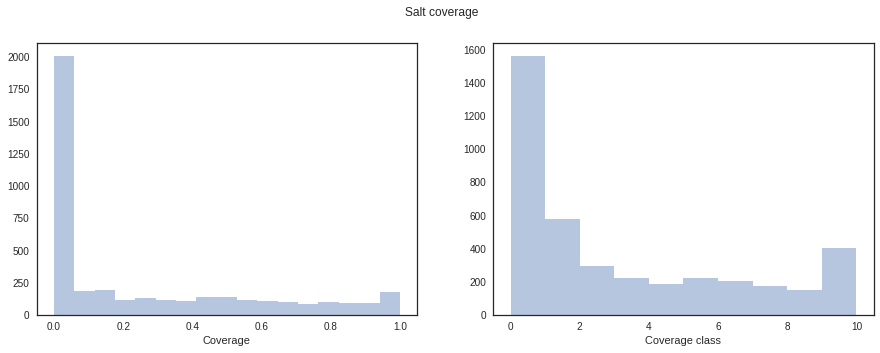

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

Text(0,0.5,'Coverage class')

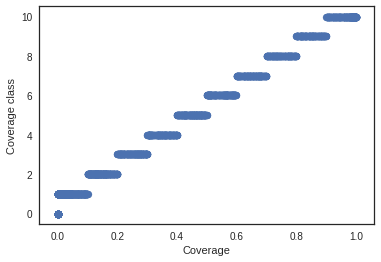

In [27]:
plt.scatter(train_df.coverage, train_df.coverage_class)
plt.xlabel("Coverage")
plt.ylabel("Coverage class")

## Depth Distribution Plot


Text(0.5,1,'Depth distribution')

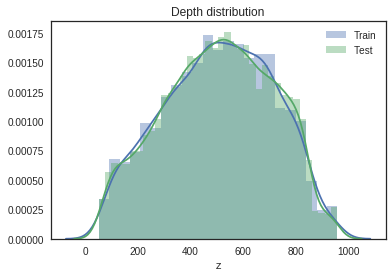

In [28]:
sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

## Visualization of some images from the data

Text(0.5,0.98,'Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

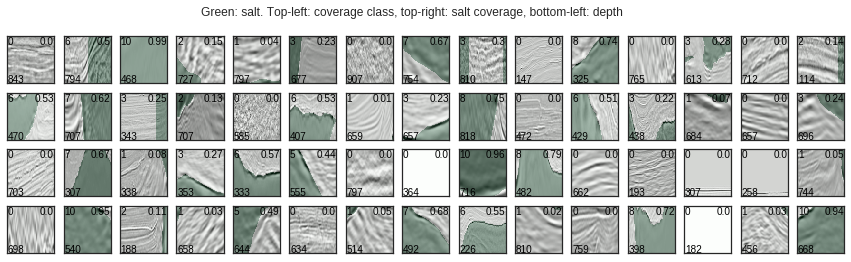

In [29]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(train_df.index[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

## Splitting the data into train and test

We are using the salt coverage as a stratification criterion here.

In [0]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=1234)

Text(0.5,1,'Scaled image')

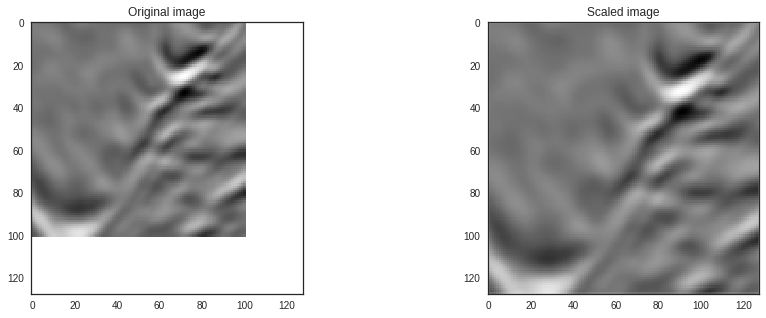

In [31]:
tmp_img = np.zeros((img_size_target, img_size_target), dtype=train_df.images.loc[ids_train[10]].dtype)
tmp_img[:img_size_ori, :img_size_ori] = train_df.images.loc[ids_train[10]]
fix, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].imshow(tmp_img, cmap="Greys")
axs[0].set_title("Original image")
axs[1].imshow(x_train[10].squeeze(), cmap="Greys")
axs[1].set_title("Scaled image")

## Building the model
Concerning the architecture of the neural net, it is based on the **U-Net architecture **introduced by "U-Net: Convolutional Networks for Biomedical Image Segmentation". It is a fully convolutional network, composed with two main parts: a downsampling and upsampling part.  The particularity is that U-net is symmetric and it creates 'skip connections' between the downsampling path and upsampling path. The goal of these skip connection is to provide local information while upsampling.

![alt text](https://static1.squarespace.com/static/5c081c159772ae210cc800e8/t/5c081e72e0c9382a1a8ca97a/1544036081058/TGS_Unet.jpg?format=750w)


In [0]:
def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    #uconv1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16)

In [0]:
model = Model(input_layer, output_layer)

In [0]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
dropout_1 

## Data Augmentation

In [0]:
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

Text(0.5,0.98,'Top row: original images, bottom row: augmented images')

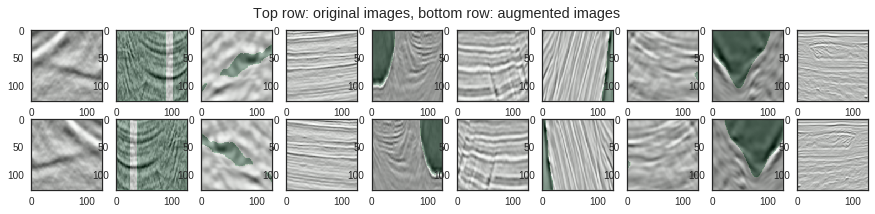

In [0]:
fig, axs = plt.subplots(2, 10, figsize=(15,3))
for i in range(10):
    axs[0][i].imshow(x_train[i].squeeze(), cmap="Greys")
    axs[0][i].imshow(y_train[i].squeeze(), cmap="Greens", alpha=0.3)
    axs[1][i].imshow(x_train[int(len(x_train)/2 + i)].squeeze(), cmap="Greys")
    axs[1][i].imshow(y_train[int(len(y_train)/2 + i)].squeeze(), cmap="Greens", alpha=0.3)
fig.suptitle("Top row: original images, bottom row: augmented images")

In [0]:
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

epochs = 200
batch_size = 32

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

Train on 6400 samples, validate on 800 samples
Epoch 1/100
6400/6400 [==============================] - 42s 7ms/step - loss: 0.1854 - acc: 0.9208 - val_loss: 0.2105 - val_acc: 0.9162

Epoch 00001: val_loss improved from inf to 0.21046, saving model to ./keras.model
Epoch 2/100
6400/6400 [==============================] - 42s 7ms/step - loss: 0.1779 - acc: 0.9222 - val_loss: 0.1931 - val_acc: 0.9127

Epoch 00002: val_loss improved from 0.21046 to 0.19308, saving model to ./keras.model
Epoch 3/100
6400/6400 [==============================] - 42s 7ms/step - loss: 0.1689 - acc: 0.9259 - val_loss: 0.2162 - val_acc: 0.9114

Epoch 00003: val_loss did not improve from 0.19308
Epoch 4/100
6400/6400 [==============================] - 42s 7ms/step - loss: 0.1716 - acc: 0.9253 - val_loss: 0.2665 - val_acc: 0.8962

Epoch 00004: val_loss did not improve from 0.19308
Epoch 5/100
6400/6400 [==============================] - 42s 7ms/step - loss: 0.1693 - acc: 0.9264 - val_loss: 0.2216 - val_acc: 0.9054

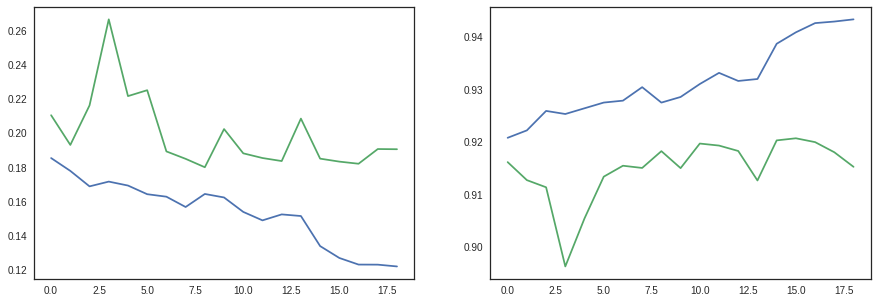

In [0]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")

In [0]:
model = load_model("./keras.model")


In [0]:
preds_valid = model.predict(x_valid).reshape(-1, img_size_target, img_size_target)
preds_valid = np.array([downsample(x) for x in preds_valid])
y_valid_ori = np.array([train_df.loc[idx].masks for idx in ids_valid])

Text(0.5,0.98,'Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

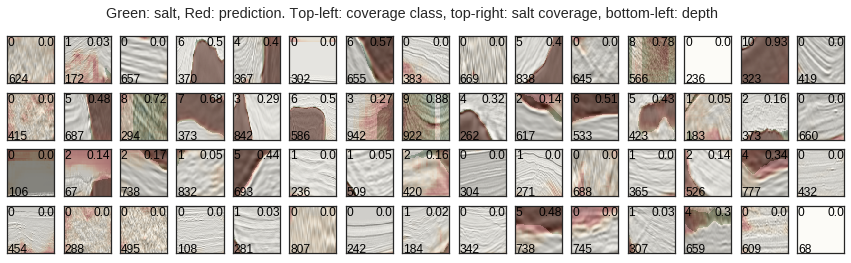

In [0]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_valid[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(pred, alpha=0.3, cmap="OrRd")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

In [0]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [0]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(y_valid_ori, np.int32(preds_valid > threshold)) for threshold in (thresholds)])

In [0]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

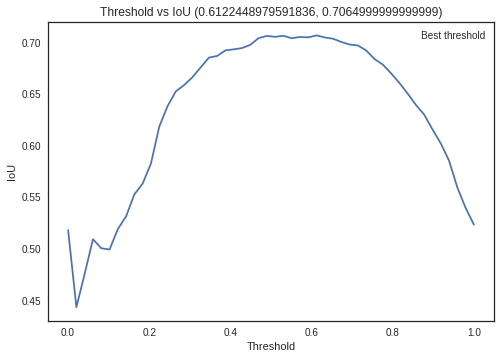

In [0]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

Text(0.5,0.98,'Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

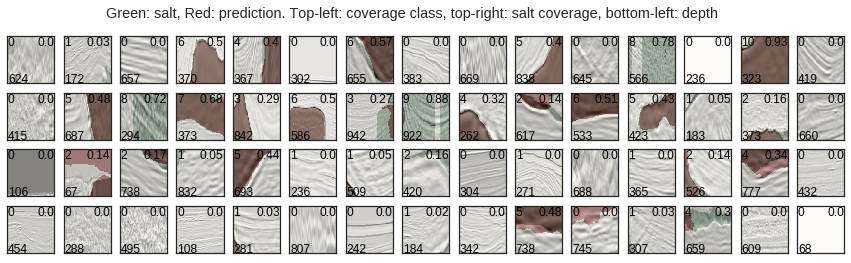

In [0]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_valid[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.3, cmap="OrRd")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

In [0]:
# Source https://www.kaggle.com/bguberfain/unet-with-depth
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [0]:
x_test = np.array([upsample(np.array(load_img("data/test/images/{}.png".format(idx), grayscale=True))) / 255 for idx in (test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [0]:
preds_test = model.predict(x_test)

In [0]:
pred_dict = {idx: RLenc(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate((test_df.index.values))}

In [0]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')

In [0]:
from google.colab import files
files.download('submission.csv') 

# Submission Details

![alt text](https://i.postimg.cc/FHxKxDvf/Screen-Shot-2018-12-23-at-12-36-37-AM.png)

## Score: 0.741254
After submmitting the 'submission.csv' file we got a score of 0.741254 and a rank of 2427 in the leaderboard.

# Imporving the score further using different unet architecture

## Importing all the necessary files for the new model

In [0]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook #, tnrange
#from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers

import tensorflow as tf

from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img
import imgaug
imgaug.seed(1)
#import time
#t_start = time.time()

In [34]:
img_size_target = 101
SUBSET = len(train_df)
train_df = train_df.head(SUBSET)
len(train_df)

4000

## Splitting the data into train and test

In [0]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state= 1234)

## Methods for the building the model architecture

In [0]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate = False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x

# The new unet model architecture

![alt text](https://cdn-images-1.medium.com/max/1263/1*aRMefObpm7AMVOZYYiQAMQ.png)



1.   Red Box → Representing the left side of U Net
2.   Blue Box → Representing the Right side of U Net
3.   Green Box → Final Bottle neck layer



a) The network is composed of Convolution Operation, Max Pooling, ReLU Activation, Concatenation and Up Sampling Layers.

b) It consists of a contracting path (left side) and an expansive path (right side).

c) The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling.

d) At each downsampling step we double the number of feature channels.

e) Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU.

f) Up-sampling can be done by using Transpose Convolution Operation.

g) The cropping is necessary due to the loss of border pixels in every convolution.

h) At the final layer a 1x1 convolution is used to map each 64 component feature vector to the desired number of classes.



In [0]:
# Build model
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
    #uconv1 = Dropout(DropoutRatio/2)(uconv1)
    #output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
    output_layer =  Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

In [0]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

### The Lovász-Softmax loss: A tractable surrogate for the optimization of the intersection-over-union measure in neural networks.
Here we use this type of loss fuction since our scoring metrics use iou.

In [0]:

def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        #loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        loss = tf.tensordot(tf.nn.elu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

## Augmenting the data further

In [40]:
#Data augmentation
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
print(x_train.shape)
print(y_valid.shape)

(6400, 101, 101, 1)
(800, 101, 101, 1)


In [41]:
# model

learning_rate = 0.01
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16,0.5)

model1 = Model(input_layer, output_layer)

c = optimizers.adam(lr = learning_rate)
model1.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric])

model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 101, 101, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 101, 101, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 101, 101, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

## Creating two files to save the model and score

In [42]:
version = 5
basic_name = f'Unet_resnet_v{version}'
save_model_name = basic_name + '.model'
submission_file = basic_name + '.csv'

print(save_model_name)
print(submission_file)

Unet_resnet_v5.model
Unet_resnet_v5.csv


## Training the model 

In [43]:
early_stopping = EarlyStopping(monitor='my_iou_metric', mode = 'max',patience=10, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name,monitor='my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='my_iou_metric', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=1)

epochs = 80
batch_size = 64
history = model1.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint,reduce_lr], 
                    verbose=2)

Train on 6400 samples, validate on 800 samples
Epoch 1/80
 - 85s - loss: 0.4250 - my_iou_metric: 0.3230 - val_loss: 1.2574 - val_my_iou_metric: 0.0597

Epoch 00001: my_iou_metric improved from -inf to 0.32295, saving model to Unet_resnet_v5.model
Epoch 2/80
 - 72s - loss: 0.3118 - my_iou_metric: 0.4698 - val_loss: 1.2432 - val_my_iou_metric: 0.3775

Epoch 00002: my_iou_metric improved from 0.32295 to 0.46978, saving model to Unet_resnet_v5.model
Epoch 3/80
 - 72s - loss: 0.2700 - my_iou_metric: 0.5109 - val_loss: 1.0837 - val_my_iou_metric: 0.3825

Epoch 00003: my_iou_metric improved from 0.46978 to 0.51089, saving model to Unet_resnet_v5.model
Epoch 4/80
 - 72s - loss: 0.2548 - my_iou_metric: 0.5260 - val_loss: 0.3599 - val_my_iou_metric: 0.2690

Epoch 00004: my_iou_metric improved from 0.51089 to 0.52597, saving model to Unet_resnet_v5.model
Epoch 5/80
 - 72s - loss: 0.2379 - my_iou_metric: 0.5530 - val_loss: 0.4399 - val_my_iou_metric: 0.5061

Epoch 00005: my_iou_metric improved fro

## Training the model with losvasz loss function for better accurcy

In [0]:
model1 = load_model(save_model_name,custom_objects={'my_iou_metric': my_iou_metric})
# remove later activation layer and use losvasz loss
input_x = model1.layers[0].input

output_layer = model1.layers[-1].input
model = Model(input_x, output_layer)
c = optimizers.adam(lr = learning_rate)

# lovasz_loss need input range (-∞，+∞), so cancel the last "sigmoid" activation  
# Then the default threshod for pixel prediction is 0 instead of 0.5, as in my_iou_metric_2.
model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 101, 101, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 101, 101, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 101, 101, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max',patience=20, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric_2', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=1)
epochs = 200
batch_size = 32

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[ model_checkpoint,reduce_lr,early_stopping], 
                    verbose=2)

Train on 6400 samples, validate on 800 samples
Epoch 1/180
 - 200s - loss: -1.6618e-01 - my_iou_metric_2: 0.8065 - val_loss: 0.1129 - val_my_iou_metric_2: 0.7612

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.76125, saving model to Unet_resnet_v5.model
Epoch 2/180
 - 177s - loss: -2.2388e-01 - my_iou_metric_2: 0.8138 - val_loss: -5.0258e-03 - val_my_iou_metric_2: 0.7817

Epoch 00002: val_my_iou_metric_2 improved from 0.76125 to 0.78175, saving model to Unet_resnet_v5.model
Epoch 3/180
 - 177s - loss: -2.4513e-01 - my_iou_metric_2: 0.8178 - val_loss: -2.1445e-02 - val_my_iou_metric_2: 0.7834

Epoch 00003: val_my_iou_metric_2 improved from 0.78175 to 0.78338, saving model to Unet_resnet_v5.model
Epoch 4/180
 - 177s - loss: -2.5837e-01 - my_iou_metric_2: 0.8173 - val_loss: 0.1686 - val_my_iou_metric_2: 0.7651

Epoch 00004: val_my_iou_metric_2 did not improve from 0.78338
Epoch 5/180
 - 177s - loss: -2.7007e-01 - my_iou_metric_2: 0.8187 - val_loss: 0.0031 - val_my_iou_metric_2: 

## Visualizing train loss and validation loss

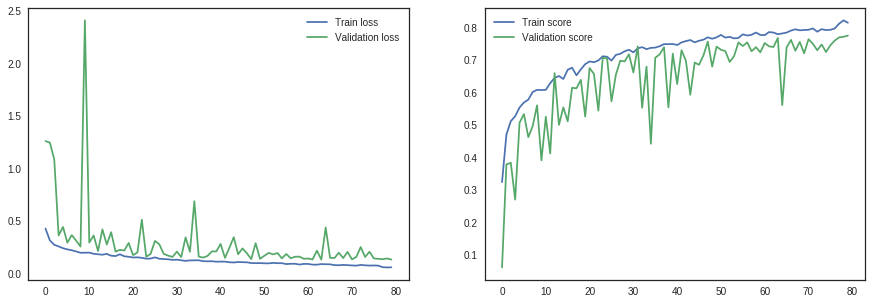

In [46]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric_2"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric_2"], label="Validation score")
ax_score.legend()

## Loading the model for prediction

In [0]:
model = load_model(save_model_name,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})

In [0]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(x) for x in preds_test2_refect] )
    return preds_test/2

In [0]:
preds_valid = predict_result(model,x_valid,img_size_target)

In [51]:
## Scoring for last model, choose threshold by validation data 
thresholds_ori = np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 

ious = np.array([iou_metric_batch(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
print(ious)


[0.523125 0.523125 0.523125 0.523125 0.523125 0.523125 0.523125 0.523125
 0.523125 0.523125 0.523125 0.523125 0.523125 0.523125 0.523125 0.523125
 0.65875  0.722375 0.757625 0.778375 0.78625  0.79     0.793375 0.799
 0.796375 0.796875 0.793625 0.788    0.783125 0.774375 0.758125]


## Plotting Threshold vs IoU

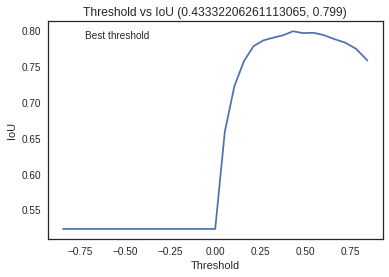

In [52]:
# instead of using default 0 as threshold, use validation data to find the best threshold.
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [0]:
"""
used for converting the decoded image to rle mask
Fast compared to previous one
"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [54]:
x_test = np.array([upsample(np.array(load_img("data/test/images/{}.png".format(idx), grayscale=True))) / 255 for idx in (test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [0]:
preds_test = predict_result(model,x_test,img_size_target)

In [0]:
pred_dict = {idx: rle_encode(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate((test_df.index.values))}

In [0]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission_file.csv')

In [0]:
from google.colab import files
files.download('submission_file.csv') 

# Second Submission


![alt text](https://i.postimg.cc/Pq036G1K/Screen-Shot-2018-12-23-at-12-38-47-AM.png)

In the second submission we got a score of 0.782783 which is an imporvement compared to the previous score.